In [7]:
!pip install rdkit
!pip install scikit-learn
!pip install lightgbm
!pip install xgboost
!pip install joblib
!pip install --upgrade pandas dask
!pip install --upgrade lightgbm


In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from xgboost import XGBRegressor
import joblib
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

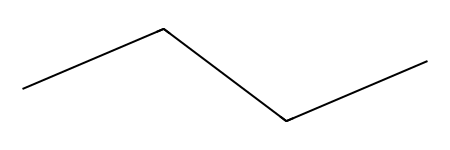

In [9]:
mol = Chem.MolFromSmiles('CCCC')
mol

In [10]:
#!/usr/bin/env python
import pandas as pd
import numpy as np

# RDKit for SMILES parsing
from rdkit import Chem
from rdkit.Chem import AllChem

# Train-test split, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# (Optional) Feature scaling
from sklearn.preprocessing import StandardScaler

# LightGBM (install via: pip install lightgbm)
import lightgbm as lgb

def smiles_to_morgan_fp(smi, radius=2, n_bits=256):
    """
    Convert a SMILES string to a Morgan fingerprint (ECFP) vector of length n_bits.
    Returns a NumPy array of shape (n_bits,) or None if the SMILES is invalid.
    
    We use 256 bits (instead of 1024) to reduce dimensionality given the small dataset.
    """
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    for i in range(n_bits):
        if fp.GetBit(i):
            arr[i] = 1
    return arr

def main():
    # 1. Load your CSV dataset (adjust filename/column names as needed)
    file_path = 'C:/Users/gagno/Downloads/molecule_dataset.csv'
    df = pd.read_csv(file_path)
    print(df.head(18))  # CSV should include 'SMILES', 'enhancement_factor', and 16 descriptor columns
    
    # 2. Basic cleaning: handle infinities and ensure 'Enhancement Factor' is numeric
    df = df.replace([np.inf, -np.inf], np.nan)
    df["Enhancement Factor"] = pd.to_numeric(df["Enhancement Factor"], errors='coerce')
    
    # Drop rows with missing values in critical columns
    df.dropna(subset=["Smiles", "Enhancement Factor"], inplace=True)
    
    # 3. Convert SMILES to numeric features (Morgan fingerprints)
    smiles_list = df["Smiles"].astype(str).tolist()
    enhancement_factors = df["Enhancement Factor"].values
    
    X_fps = []
    valid_y = []
    for smi, val in zip(smiles_list, enhancement_factors):
        fp = smiles_to_morgan_fp(smi, radius=2, n_bits=256)
        if fp is not None:
            X_fps.append(fp)
            valid_y.append(val)
    X = np.array(X_fps, dtype=float)
    y = np.array(valid_y, dtype=float)
    
    # 4. Train-test split
    #    We'll do 80-20 here, but with only 16 rows, cross-validation is recommended.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # 5. (Optional) Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    # 6. Define and train a LightGBM regressor
    #    Adjust n_estimators, learning_rate, and other params via cross-validation if needed.
    lgbm_reg = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    )
    lgbm_reg.fit(X_train_scaled, y_train)
    
    # 7. Evaluate on the test set
    y_pred = lgbm_reg.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Adjusted R² = 1 - (1 - R²)*(n - 1)/(n - p - 1)
    n = len(y_test)
    p = X_test_scaled.shape[1]  # e.g., 256 if not reduced further
    if n > p + 1:
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    else:
        adjusted_r2 = float('nan')  # Not well-defined if p >= n-1
    
    print("\n=== LightGBM Model (Test Set) ===")
    print("n_estimators=100, learning_rate=0.1, random_state=42")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"R²   : {r2:.4f}")
    print(f"Adjusted R²: {adjusted_r2:.4f}")
    
    # 8. Retrain on the entire dataset for new SMILES predictions
    final_model = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    )
    X_scaled = scaler.fit_transform(X)
    final_model.fit(X_scaled, y)
    
    # 9. Interactive input for new SMILES outside the dataset
    print("\n=== Predict Enhancement Factor for a new SMILES ===")
    while True:
        user_input = input("Enter a SMILES string (or type 'quit' to exit): ").strip()
        if user_input.lower() == 'quit':
            print("Exiting.")
            break
        
        new_fp = smiles_to_morgan_fp(user_input, radius=2, n_bits=256)
        if new_fp is None:
            print("Invalid SMILES entered. Please try again.\n")
            continue
        
        # Scale the new fingerprint
        new_fp_scaled = scaler.transform([new_fp])
        pred_val = final_model.predict(new_fp_scaled)[0]
        print(f"Predicted Enhancement Factor: {pred_val:.4f}\n")

if __name__ == "__main__":
    main()


    ID                         Name  \
0     1         Ibuprofen / HP-B-CD   
1     2      Dexamethasone / B - CD   
2     3         Piroxicam / HP-B-CD   
3     4    Hydrocortisone / HP-B-CD   
4     5       Albendazole / RM-B-CD   
5     6            Valtarsan / B-CD   
6     7        Nifedipine / HP-B-CD   
7     8        Nimodipine / HP-B-CD   
8     9     Carbamazepine / HP-B-CD   
9    10      Itraconazole / HP-B-CD   
10   11       Simvastatin / HP-B-CD   
11   12          Curcumin / HP-B-CD   
12   13  Indomethacin / HP- B - CD    
13   14     Naproxen / HP - B - CD    
14   15        Diclofenac / HP-B-CD   
15   16   Resveratrol / HP-Gamma CD   

                                               Smiles MolWeight   LogP  HBD  \
0                          CC(C)Cc1ccc(cc1)C(C)C(=O)O   1606.29 -1.641  NaN   
1   CC(C)C1C(=O)CC2C(C1O)(CC(C1=CC(=O)C=C2C1(C)O)F...   1527.47 -1.560  NaN   
2                     CN1NS(=O)(=O)C2=C(O)C=CN=C2C1=O   1466.35 -1.500  NaN   
3              CC(=O

[17:41:46] DEPRECATION WARNING: please use MorganGenerator
[17:41:46] DEPRECATION WARNING: please use MorganGenerator
[17:41:46] DEPRECATION WARNING: please use MorganGenerator
[17:41:47] DEPRECATION WARNING: please use MorganGenerator
[17:41:47] DEPRECATION WARNING: please use MorganGenerator
[17:41:47] DEPRECATION WARNING: please use MorganGenerator
[17:41:47] DEPRECATION WARNING: please use MorganGenerator
[17:41:47] DEPRECATION WARNING: please use MorganGenerator
[17:41:47] DEPRECATION WARNING: please use MorganGenerator
[17:41:47] DEPRECATION WARNING: please use MorganGenerator
[17:41:47] DEPRECATION WARNING: please use MorganGenerator
[17:41:47] DEPRECATION WARNING: please use MorganGenerator
[17:41:47] DEPRECATION WARNING: please use MorganGenerator
[17:41:47] DEPRECATION WARNING: please use MorganGenerator
[17:41:47] DEPRECATION WARNING: please use MorganGenerator
[17:41:47] DEPRECATION WARNING: please use MorganGenerator
C:\Users\gagno\anaconda3\lib\site-packages\sklearn\utils

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 12, number of used features: 0
[LightGBM] [Info] Start training from score 2337.723430
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

Enter a SMILES string (or type 'quit' to exit): quit
Exiting.


Here is an improved version of algorithm:

In [1]:
#!/usr/bin/env python
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb

def smiles_to_morgan_fp(smi, radius=2, n_bits=256):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    for i in range(n_bits):
        if fp.GetBit(i):
            arr[i] = 1
    return arr

def main():
    file_path = 'C:/Users/gagno/Downloads/molecule_dataset.csv'
    df = pd.read_csv(file_path)
    print(df.head(18))  # CSV should include 'SMILES', 'enhancement_factor', and 16 descriptor columns
    
    df = df.replace([np.inf, -np.inf], np.nan)
    df["Enhancement Factor"] = pd.to_numeric(df["Enhancement Factor"], errors='coerce')
    df.dropna(subset=["Smiles", "Enhancement Factor"], inplace=True)
    
    # Convert SMILES to fingerprints
    smiles_list = df["Smiles"].astype(str).tolist()
    enhancement_factors = df["Enhancement Factor"].values
    
    X_fps = []
    valid_y = []
    for smi, val in zip(smiles_list, enhancement_factors):
        fp = smiles_to_morgan_fp(smi, radius=2, n_bits=256)
        if fp is not None:
            X_fps.append(fp)
            valid_y.append(val)
    
    X = np.array(X_fps, dtype=float)
    y = np.array(valid_y, dtype=float)

    # Quick check: are all fingerprints identical?
    print("Unique rows in X:", np.unique(X, axis=0).shape[0])

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Optional scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # LightGBM with relaxed leaf/bins
    lgbm_reg = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
        min_data_in_leaf=1,  # was 20 by default
        min_data_in_bin=1    # reduce bin constraints
    )
    lgbm_reg.fit(X_train_scaled, y_train)

    # Evaluate
    y_pred = lgbm_reg.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    n = len(y_test)
    p = X_test_scaled.shape[1]
    if n > p + 1:
        adjusted_r2 = 1 - (1 - r2)*(n - 1)/(n - p - 1)
    else:
        adjusted_r2 = float('nan')

    print("\n=== LightGBM Model (Test Set) ===")
    print("With min_data_in_leaf=1, min_data_in_bin=1")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"R²   : {r2:.4f}")
    print(f"Adjusted R²: {adjusted_r2:.4f}")

    # Retrain on all data
    final_model = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
        min_data_in_leaf=1,
        min_data_in_bin=1
    )
    X_scaled = scaler.fit_transform(X)
    final_model.fit(X_scaled, y)

    # Predict new SMILES
    while True:
        user_input = input("\nEnter SMILES (or 'quit'): ").strip()
        if user_input.lower() == 'quit':
            break
        new_fp = smiles_to_morgan_fp(user_input, radius=2, n_bits=256)
        if new_fp is None:
            print("Invalid SMILES. Try again.")
            continue
        new_fp_scaled = scaler.transform([new_fp])
        pred_val = final_model.predict(new_fp_scaled)[0]
        print(f"Predicted Enhancement Factor: {pred_val:.4f}")

if __name__ == "__main__":
    main()



    ID                         Name  \
0     1         Ibuprofen / HP-B-CD   
1     2      Dexamethasone / B - CD   
2     3         Piroxicam / HP-B-CD   
3     4    Hydrocortisone / HP-B-CD   
4     5       Albendazole / RM-B-CD   
5     6            Valtarsan / B-CD   
6     7        Nifedipine / HP-B-CD   
7     8        Nimodipine / HP-B-CD   
8     9     Carbamazepine / HP-B-CD   
9    10      Itraconazole / HP-B-CD   
10   11       Simvastatin / HP-B-CD   
11   12          Curcumin / HP-B-CD   
12   13  Indomethacin / HP- B - CD    
13   14     Naproxen / HP - B - CD    
14   15        Diclofenac / HP-B-CD   
15   16   Resveratrol / HP-Gamma CD   
16   17              Amphotericin B   
17   18                 Budesonide    

                                               Smiles MolWeight  LogP  \
0                          CC(C)Cc1ccc(cc1)C(C)C(=O)O   1606.29  3.84   
1   CC(C)C1C(=O)CC2C(C1O)(CC(C1=CC(=O)C=C2C1(C)O)F...   1527.47  1.93   
2                     CN1NS(=O)(=O)C2=C

[23:54:46] DEPRECATION WARNING: please use MorganGenerator
[23:54:46] DEPRECATION WARNING: please use MorganGenerator
[23:54:46] DEPRECATION WARNING: please use MorganGenerator
[23:54:46] DEPRECATION WARNING: please use MorganGenerator
[23:54:46] DEPRECATION WARNING: please use MorganGenerator
[23:54:46] DEPRECATION WARNING: please use MorganGenerator
[23:54:46] DEPRECATION WARNING: please use MorganGenerator
[23:54:46] DEPRECATION WARNING: please use MorganGenerator
[23:54:46] DEPRECATION WARNING: please use MorganGenerator
[23:54:46] DEPRECATION WARNING: please use MorganGenerator
[23:54:46] DEPRECATION WARNING: please use MorganGenerator
[23:54:46] DEPRECATION WARNING: please use MorganGenerator
[23:54:46] DEPRECATION WARNING: please use MorganGenerator
[23:54:46] DEPRECATION WARNING: please use MorganGenerator
[23:54:46] DEPRECATION WARNING: please use MorganGenerator
[23:54:46] DEPRECATION WARNING: please use MorganGenerator
[23:54:46] DEPRECATION WARNING: please use MorganGenerat

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1

=== LightGBM Model (Test Set) ===
With min_data_in_leaf=1, min_data_in_bin=1
MSE  : 211589.1068
RMSE : 459.9882
MAE  : 299.8526
R²   : -0.7274
Adjusted R²: nan
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 252
[LightGBM] [Info] Start training from score 1459.408718

Enter SMILES (or 'quit'): quit


Here is much more imrpoved version even
=
=
=
=
=
=
=
=
=
=
=


In [3]:
#!/usr/bin/env python
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Lipinski

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def smiles_to_morgan_fp(smi, radius=3, n_bits=1024):
    """Convert SMILES to Morgan fingerprint with more bits and larger radius"""
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    for i in range(n_bits):
        if fp.GetBit(i):
            arr[i] = 1
    return arr

def calculate_additional_descriptors(smi):
    """Calculate additional molecular descriptors to enrich the model"""
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    
    descriptors = []
    
    # Basic properties
    descriptors.append(Descriptors.MolWt(mol))             # Molecular weight
    descriptors.append(Descriptors.MolLogP(mol))           # LogP
    descriptors.append(Descriptors.TPSA(mol))              # Topological polar surface area
    
    # Hydrogen bond features
    descriptors.append(Lipinski.NumHDonors(mol))           # H-bond donors
    descriptors.append(Lipinski.NumHAcceptors(mol))        # H-bond acceptors
    
    # Structural features
    descriptors.append(Descriptors.NumRotatableBonds(mol)) # Rotatable bonds
    descriptors.append(Descriptors.NumAromaticRings(mol))  # Aromatic rings
    descriptors.append(Descriptors.NumHeteroatoms(mol))    # Number of heteroatoms
    descriptors.append(Descriptors.FractionCSP3(mol))      # Fraction of sp3 carbons
    
    # Electronic properties
    descriptors.append(Descriptors.NumRadicalElectrons(mol)) # Radical electrons
    descriptors.append(Descriptors.MaxPartialCharge(mol) if hasattr(Descriptors, 'MaxPartialCharge') else 0)
    descriptors.append(Descriptors.MinPartialCharge(mol) if hasattr(Descriptors, 'MinPartialCharge') else 0)
    
    return descriptors

def main():
    print("Loading dataset...")
    file_path = 'C:/Users/gagno/Downloads/molecule_dataset.csv'
    df = pd.read_csv(file_path)
    
    # Clean data
    df = df.replace([np.inf, -np.inf], np.nan)
    df["Enhancement Factor"] = pd.to_numeric(df["Enhancement Factor"], errors='coerce')
    df.dropna(subset=["Smiles", "Enhancement Factor"], inplace=True)
    
    print(f"Dataset loaded. Shape: {df.shape}")
    print(f"Enhancement Factor range: {df['Enhancement Factor'].min()} to {df['Enhancement Factor'].max()}")
    
    # Transform target to log scale to handle wide range of values
    y_original = df["Enhancement Factor"].values
    y = np.log1p(y_original)  # Log transform for better handling of wide range
    
    # Extract features
    smiles_list = df["Smiles"].astype(str).tolist()
    
    # Prepare feature matrix with both fingerprints and descriptors
    X_combined = []
    valid_indices = []
    
    print("Generating molecular features...")
    for i, smi in enumerate(smiles_list):
        # Get Morgan fingerprint
        fp = smiles_to_morgan_fp(smi, radius=3, n_bits=1024)
        
        # Get additional descriptors
        descriptors = calculate_additional_descriptors(smi)
        
        if fp is not None and descriptors is not None:
            features = np.concatenate([fp, descriptors])
            X_combined.append(features)
            valid_indices.append(i)
    
    X = np.array(X_combined, dtype=float)
    y = y[valid_indices]  # Keep only valid molecules
    y_original = y_original[valid_indices]
    
    print(f"Features generated. X shape: {X.shape}")
    
    # Feature selection - removing constant features
    non_constant_cols = np.where(X.std(axis=0) > 0)[0]
    X = X[:, non_constant_cols]
    print(f"After removing constant features: {X.shape}")
    
    # Train-test split with stratification based on binned target values
    y_bins = pd.qcut(y, q=5, labels=False, duplicates='drop')
    X_train, X_test, y_train, y_test, y_orig_train, y_orig_test = train_test_split(
        X, y, y_original, test_size=0.2, random_state=42, stratify=y_bins
    )
    
    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Hyperparameter optimization using Grid Search
    print("Optimizing hyperparameters...")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [7, 15, 31],
        'min_child_samples': [1, 3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0, 0.1, 0.5]
    }
    
    lgbm_base = lgb.LGBMRegressor(
        objective='regression',
        metric='rmse',
        verbose=-1,
        random_state=42
    )
    
    # Use 5-fold cross-validation for hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=lgbm_base,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    # Get best parameters
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    
    # Train final model with best parameters
    lgbm_reg = lgb.LGBMRegressor(
        **best_params,
        random_state=42,
        verbose=-1
    )
    
    # Cross-validation assessment
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(
        lgbm_reg, X_train_scaled, y_train, 
        cv=cv, scoring='r2', n_jobs=-1
    )
    
    print(f"Cross-validation R² scores: {cv_scores}")
    print(f"Mean CV R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Train final model on all training data
    lgbm_reg.fit(X_train_scaled, y_train)
    
    # Predict on test set (log-transformed space)
    y_pred_log = lgbm_reg.predict(X_test_scaled)
    
    # Convert predictions back to original scale
    y_pred = np.expm1(y_pred_log)
    
    # Evaluate on both scales
    # Log-transformed scale metrics
    mse_log = mean_squared_error(y_test, y_pred_log)
    rmse_log = np.sqrt(mse_log)
    mae_log = mean_absolute_error(y_test, y_pred_log)
    r2_log = r2_score(y_test, y_pred_log)
    
    # Original scale metrics
    mse = mean_squared_error(y_orig_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_orig_test, y_pred)
    r2 = r2_score(y_orig_test, y_pred)
    
    print("\n=== LightGBM Model (Test Set) ===")
    print(f"Log-transformed space:")
    print(f"MSE  : {mse_log:.4f}")
    print(f"RMSE : {rmse_log:.4f}")
    print(f"MAE  : {mae_log:.4f}")
    print(f"R²   : {r2_log:.4f}")
    
    print(f"\nOriginal space:")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"R²   : {r2:.4f}")
    
    # Feature importance
    importance = lgbm_reg.feature_importances_
    top_indices = importance.argsort()[-20:][::-1]  # Get top 20 features
    
    feature_names = [f"Feature_{i}" for i in range(X.shape[1])]
    for i, idx in enumerate(top_indices):
        print(f"Top {i+1} feature ({feature_names[idx]}): {importance[idx]}")
    
    # Visualization of predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_orig_test, y_pred, alpha=0.7)
    plt.plot([min(y_orig_test), max(y_orig_test)], [min(y_orig_test), max(y_orig_test)], 'r--')
    plt.xlabel('Actual Enhancement Factor')
    plt.ylabel('Predicted Enhancement Factor')
    plt.title('LGBM Model: Actual vs Predicted Enhancement Factor')
    plt.savefig('prediction_plot.png')
    plt.close()
    
    # Retrain on all data for deployment
    print("\nTraining final model on all data...")
    X_all_scaled = scaler.fit_transform(X)
    
    final_model = lgb.LGBMRegressor(
        **best_params,
        random_state=42,
        verbose=-1
    )
    final_model.fit(X_all_scaled, y)
    
    # Prediction interface
    print("\nModel ready for predictions!")
    while True:
        user_input = input("\nEnter SMILES (or 'quit'): ").strip()
        if user_input.lower() == 'quit':
            break
            
        # Process new molecule
        new_fp = smiles_to_morgan_fp(user_input, radius=3, n_bits=1024)
        new_descriptors = calculate_additional_descriptors(user_input)
        
        if new_fp is None or new_descriptors is None:
            print("Invalid SMILES. Try again.")
            continue
            
        new_features = np.concatenate([new_fp, new_descriptors])
        new_features = new_features[non_constant_cols]  # Apply same feature selection
        new_features_scaled = scaler.transform([new_features])
        
        # Predict in log space then convert back
        pred_log = final_model.predict(new_features_scaled)[0]
        pred_val = np.expm1(pred_log)
        
        print(f"Predicted Enhancement Factor: {pred_val:.4f}")

if __name__ == "__main__":
    main()

Loading dataset...
Dataset loaded. Shape: (51, 11)
Enhancement Factor range: 0.221698113 to 27000.0
Generating molecular features...
Features generated. X shape: (51, 1036)
After removing constant features: (51, 893)
Optimizing hyperparameters...


[00:04:43] DEPRECATION WARNING: please use MorganGenerator
[00:04:43] DEPRECATION WARNING: please use MorganGenerator
[00:04:43] DEPRECATION WARNING: please use MorganGenerator
[00:04:43] DEPRECATION WARNING: please use MorganGenerator
[00:04:43] DEPRECATION WARNING: please use MorganGenerator
[00:04:43] DEPRECATION WARNING: please use MorganGenerator
[00:04:43] DEPRECATION WARNING: please use MorganGenerator
[00:04:43] DEPRECATION WARNING: please use MorganGenerator
[00:04:43] DEPRECATION WARNING: please use MorganGenerator
[00:04:43] DEPRECATION WARNING: please use MorganGenerator
[00:04:43] DEPRECATION WARNING: please use MorganGenerator
[00:04:43] DEPRECATION WARNING: please use MorganGenerator
[00:04:43] DEPRECATION WARNING: please use MorganGenerator
[00:04:43] DEPRECATION WARNING: please use MorganGenerator
[00:04:43] DEPRECATION WARNING: please use MorganGenerator
[00:04:43] DEPRECATION WARNING: please use MorganGenerator
[00:04:43] DEPRECATION WARNING: please use MorganGenerat

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'min_child_samples': 5, 'n_estimators': 50, 'num_leaves': 7, 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'subsample': 0.8}
Cross-validation R² scores: [-0.05044144 -4.01870591 -1.05792887 -0.07624155 -0.89330797]
Mean CV R²: -1.2193 ± 1.4589

=== LightGBM Model (Test Set) ===
Log-transformed space:
MSE  : 6.8503
RMSE : 2.6173
MAE  : 1.9991
R²   : 0.0206

Original space:
MSE  : 52332066.6619
RMSE : 7234.0906
MAE  : 2271.1179
R²   : -0.1054
Top 1 feature (Feature_891): 36
Top 2 feature (Feature_884): 28
Top 3 feature (Feature_882): 23
Top 4 feature (Feature_585): 20
Top 5 feature (Feature_889): 19
Top 6 feature (Feature_881): 19
Top 7 feature (Feature_886): 16
Top 8 feature (Feature_149): 15
Top 9 feature (Feature_474): 14
Top 10 feature (Feature_303): 10
Top 11 feature (Feature_892): 9
Top 12 feature (Feature_883): 9
Top 13 feature (Feature_416): 7
Top 14 feature (Feature_257): 7
Top 15 feature (Feature_82): 5
Top 16 feature (Fe